# 数据加载

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# df是一个数据框，调用pandas库中read_csv函数将指定路径下的数据加载到df数据框中
df = pd.read_csv('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/【日度201912】Foreign_Exchange_Rates.csv')
# 通过下述代码将DataFrame中的数据转为数值类型
# 选取除了Time Series列以外的所有列，第一个为行，第二个为列
selected_columns = df.loc[:, df.columns != 'Time Serie']
# apply函数可以将运算作用到表格内所有数据上，第一个为函数（转化为数值），第二个为转化失败时的操作（此处为不做处理）
selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')
# update方法会将selected_columns中的值替换到df中对应的位置。
df.update(selected_columns)
df['Time Serie'] = pd.to_datetime(df['Time Serie'])
df['Time Serie']

0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
5212   2019-12-25
5213   2019-12-26
5214   2019-12-27
5215   2019-12-30
5216   2019-12-31
Name: Time Serie, Length: 5217, dtype: datetime64[ns]

In [31]:
print(df.dtypes)

Unnamed: 0                                            int64
Time Serie                                   datetime64[ns]
AUSTRALIA - AUSTRALIAN DOLLAR/US$                    object
EURO AREA - EURO/US$                                 object
NEW ZEALAND - NEW ZELAND DOLLAR/US$                  object
UNITED KINGDOM - UNITED KINGDOM POUND/US$            object
BRAZIL - REAL/US$                                    object
CANADA - CANADIAN DOLLAR/US$                         object
CHINA - YUAN/US$                                     object
HONG KONG - HONG KONG DOLLAR/US$                     object
INDIA - INDIAN RUPEE/US$                             object
KOREA - WON/US$                                      object
MEXICO - MEXICAN PESO/US$                            object
SOUTH AFRICA - RAND/US$                              object
SINGAPORE - SINGAPORE DOLLAR/US$                     object
DENMARK - DANISH KRONE/US$                           object
JAPAN - YEN/US$                         

# 数据预处理

In [32]:
# 填充缺失值，先从下往上填充，再从上往下填充
df = df.replace("ND", np.nan)
# backwardfill  forwardfill
df = df.bfill().ffill()

In [33]:
# 先判断数据是否为空，然后进行加总，本质是要找到非空数据的数量
num = df.isnull().sum()
len(df)

5217

In [34]:
print("Total number of days between {} and {} are {}".format(df['Time Serie'].min().date(), df['Time Serie'].max().date(), (df['Time Serie'].max() - df['Time Serie'].min()).days+1))

Total number of days between 2000-01-03 and 2019-12-31 are 7303


In [35]:
# 计算时间范围内的总天数
num_records = (df['Time Serie'].max() - df['Time Serie'].min()).days+1
# 创建完整的时间序列，先建立一个空列表，然后生成一个字典，值为以日为频率的起始和结束日期
data = {}
data["Time Serie"] = pd.date_range(df['Time Serie'].min().date(), df['Time Serie'].max().date(), freq="D")
# 利用pd中的dataframe函数生成一个新的dataframe，数据就是data里的数据
df_full = pd.DataFrame(data=data)
# df_full = df_full.set_index("DATE")
df_full = df_full.merge(df, left_index=True, right_index=True, how="left")
df_full = df_full.bfill().ffill()

In [36]:
df_full.head

<bound method NDFrame.head of      Time Serie_x  Unnamed: 0 Time Serie_y  AUSTRALIA - AUSTRALIAN DOLLAR/US$  \
0      2000-01-03         0.0   2000-01-03                             1.5172   
1      2000-01-04         1.0   2000-01-04                             1.5239   
2      2000-01-05         2.0   2000-01-05                             1.5267   
3      2000-01-06         3.0   2000-01-06                             1.5291   
4      2000-01-07         4.0   2000-01-07                             1.5272   
...           ...         ...          ...                                ...   
7298   2019-12-27      5216.0   2019-12-31                             1.4225   
7299   2019-12-28      5216.0   2019-12-31                             1.4225   
7300   2019-12-29      5216.0   2019-12-31                             1.4225   
7301   2019-12-30      5216.0   2019-12-31                             1.4225   
7302   2019-12-31      5216.0   2019-12-31                             1.4225  

In [38]:
# 计算所有汇率相对于人民币的值
# 首先修改标签，原先是所有货币相对于美元
cols = [col.replace("US$", "YUAN") for col in df.columns]
# 新建关于人民币的dataframe，数据来源是df，标签名称为cols
yuan_df = pd.DataFrame(data = df, columns=cols)
# （iloc用序号如0、1、2，loc用名称如Time series），从第三列开始每列的数据都变为原始数据除以人民币兑美元
yuan_df.iloc[:, 2:] = df.iloc[:, 2:].div(df['CHINA - YUAN/US$'], axis=0)
yuan_df.iloc[:, 2:] = yuan_df.iloc[:, 2:].applymap(lambda x: 1/x)
yuan_df['US$/YUAN'] = df['CHINA - YUAN/US$']
yuan_df.head

<bound method NDFrame.head of       Unnamed: 0 Time Serie  AUSTRALIA - AUSTRALIAN DOLLAR/YUAN  \
0              0 2000-01-03                            5.457290   
1              1 2000-01-04                            5.433362   
2              2 2000-01-05                            5.423331   
3              3 2000-01-06                            5.414754   
4              4 2000-01-07                            5.421294   
...          ...        ...                                 ...   
5212        5212 2019-12-25                            4.853862   
5213        5213 2019-12-26                            4.853862   
5214        5214 2019-12-27                            4.881306   
5215        5215 2019-12-30                            4.893122   
5216        5216 2019-12-31                            4.894060   

      EURO AREA - EURO/YUAN  NEW ZEALAND - NEW ZELAND DOLLAR/YUAN  \
0                  8.408449                              4.350234   
1                  8.535979

In [41]:
# 删除人民币兑人民币
yuan_df = yuan_df.drop(columns = ['CHINA - YUAN/YUAN'])

In [42]:
yuan_df.to_csv('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/renminbi-exchangerate')

# 数据展示

In [50]:
def scatter_plot(df, country):
    # 遍历 df.columns 中的每个列名 col，并根据条件筛选出符合条件的列名，最终生成一个列表
  selected_col = [col for col in df.columns if country.lower() in col.lower()]
    # 添加时间序列一列
  selected_col.insert(0, 'Time Serie')
    # 选出被需要的两列
  df_show = df[selected_col]
  for index in range(len(selected_col) - 1):
    # plot
    plt.figure(figsize=(18,6))
    # size and color:
    plt.scatter(df_show['Time Serie'], df_show.iloc[:,index + 1])
    plt.title(df_show.columns[index+1], fontsize = 20,fontweight = 'bold', color='blue')
    plt.xlabel("Date", fontsize = 14, fontweight='bold', color='red')
    plt.ylabel('Exchange Rate', fontsize = 14, fontweight='bold', color='red')
    plt.show()

def line_plot(df, country):
    # 遍历 df.columns 中的每个列名 col，并根据条件筛选出符合条件的列名，最终生成一个列表
    selected_col = [col for col in df.columns if country.lower() in col.lower()]
    # 添加时间序列一列
    selected_col.insert(0, 'Time Serie')
    # 选出被需要的两列
    df_show = df[selected_col]
    
    for index in range(len(selected_col) - 1):
        # plot
        plt.figure(figsize=(18, 6))
        # 绘制折线图
        plt.plot(df_show['Time Serie'], df_show.iloc[:, index + 1], linestyle='-')
        plt.title(df_show.columns[index + 1], fontsize=20, fontweight='bold', color='blue')
        plt.xlabel("Date", fontsize=14, fontweight='bold', color='red')
        plt.ylabel('Exchange Rate', fontsize=14, fontweight='bold', color='red')
        plt.xticks(rotation=45)  # 旋转 x 轴标签，避免重叠
        plt.grid(True)  # 添加网格线
        plt.tight_layout()  # 自动调整布局
        plt.show()

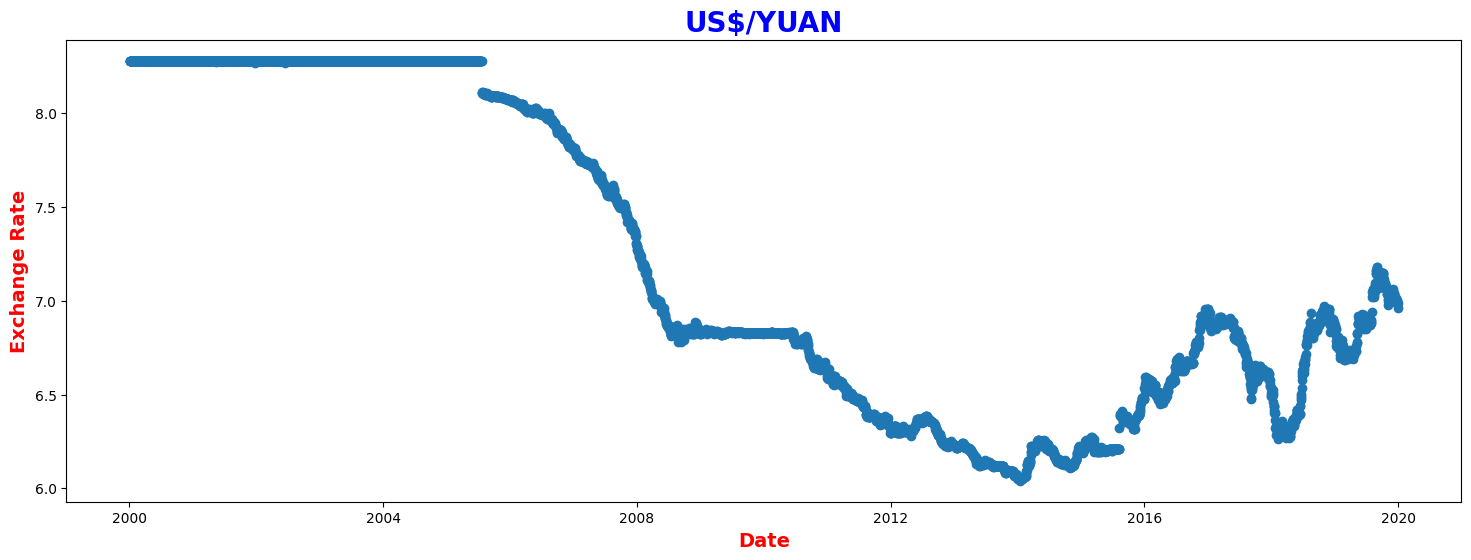

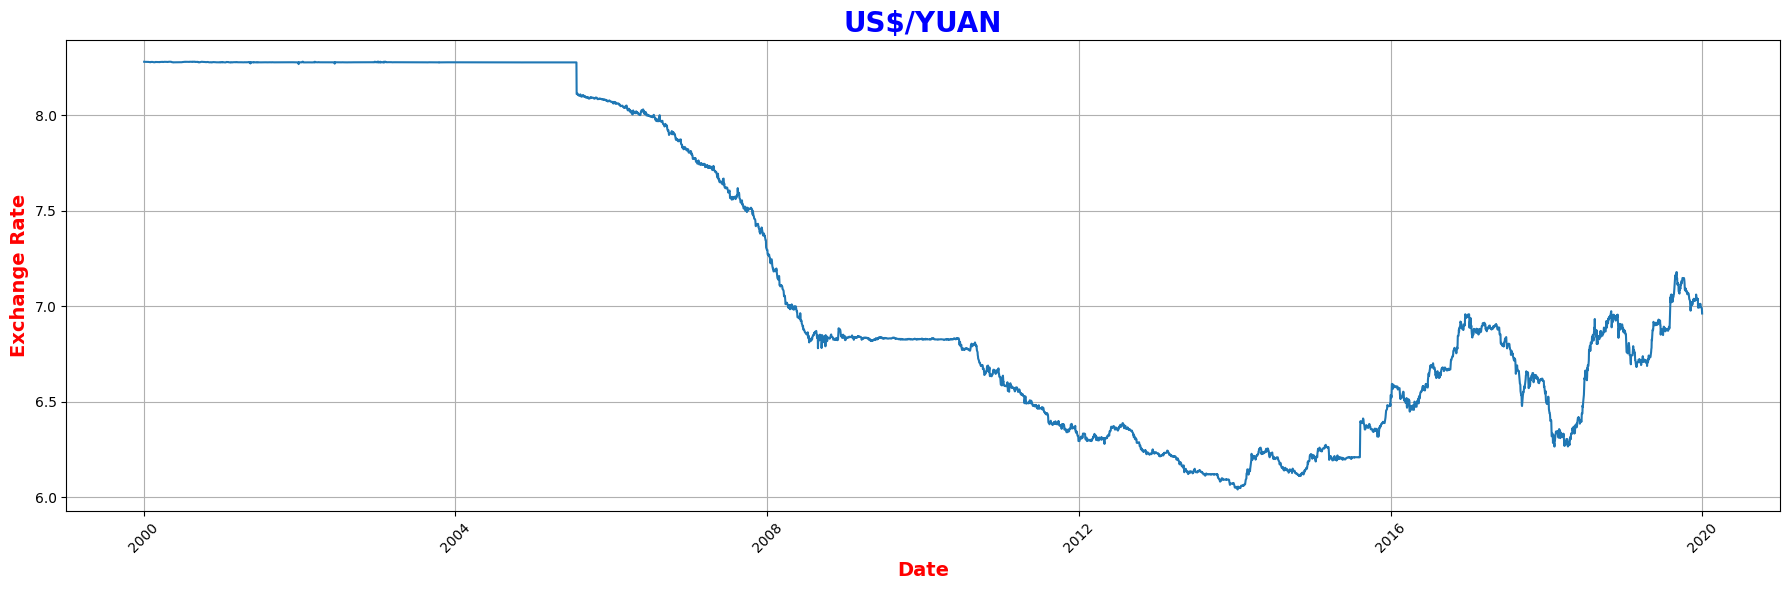

In [51]:
scatter_plot(yuan_df, "US$")
line_plot(yuan_df, "US$")

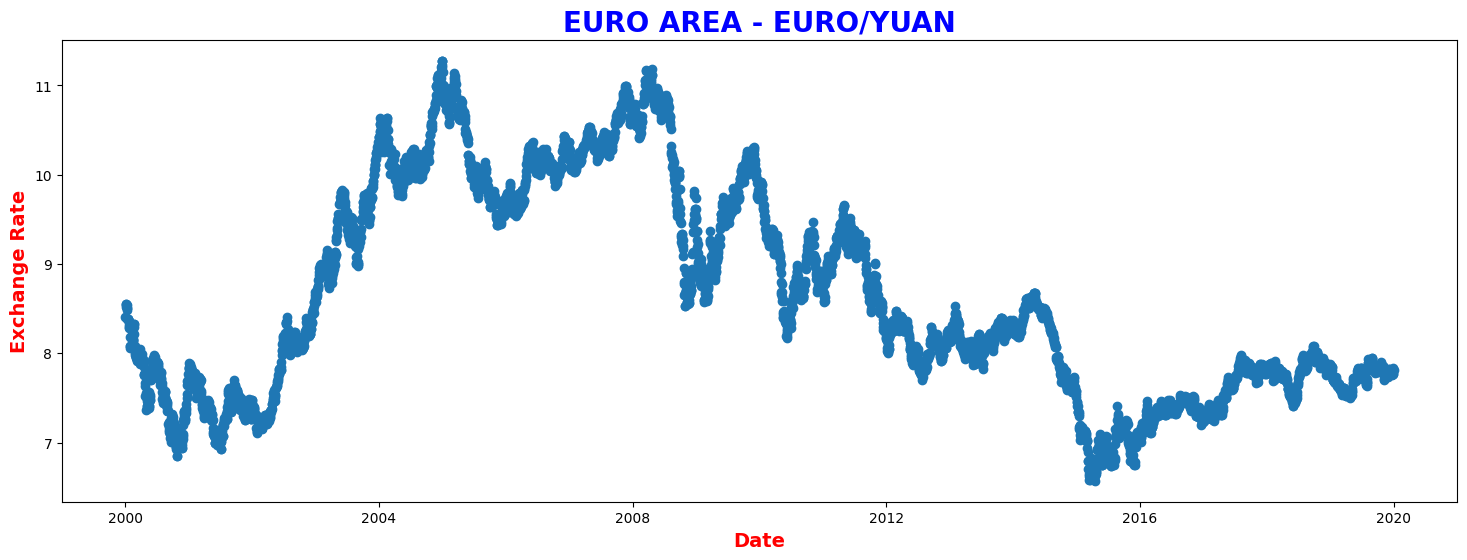

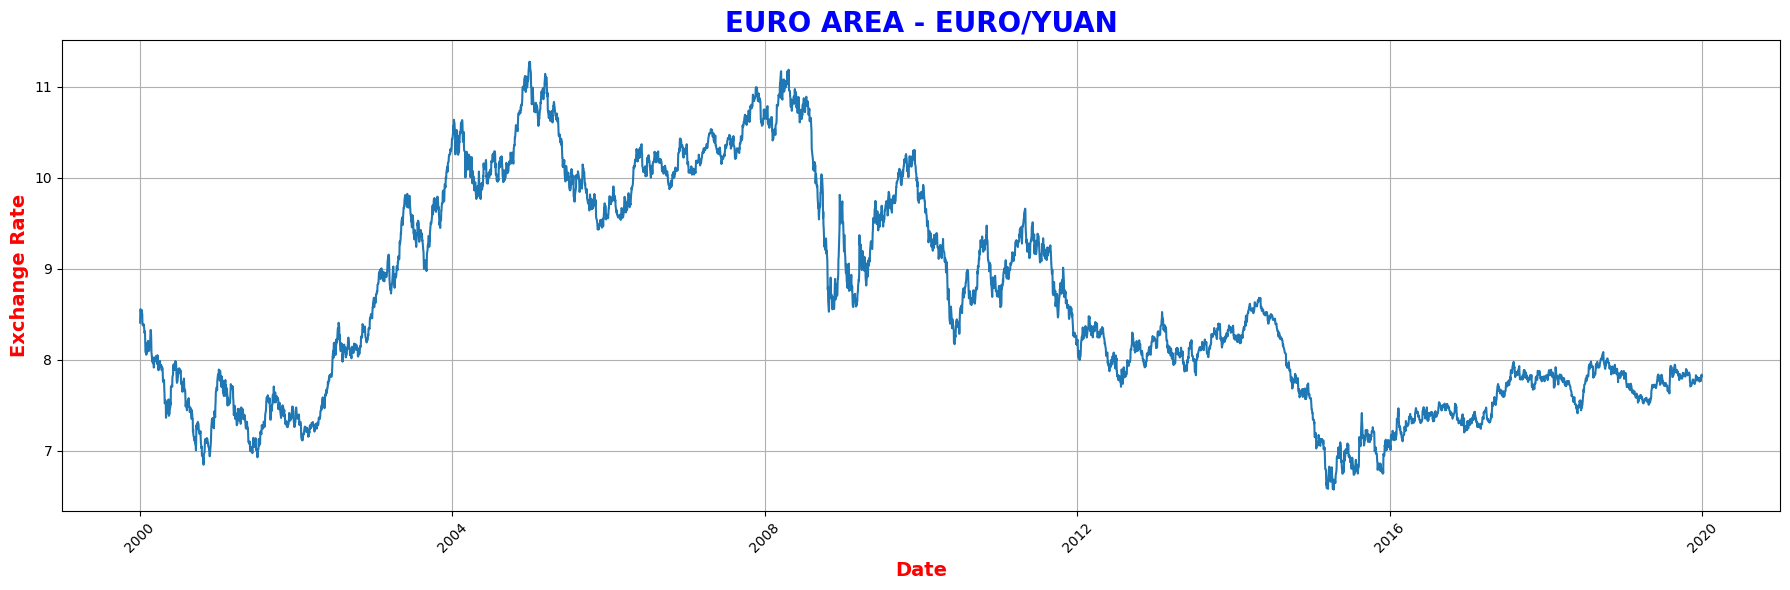

In [53]:
scatter_plot(yuan_df, 'EURO')
line_plot(yuan_df, "EURO")

# 使用LSTM对US$ /YUAN预测

### STEP1 数据准备

In [79]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#Defining the LSTM model
from keras.models import Sequential
from keras.layers import Dense,LSTM
import torch

In [80]:
# 加载处理后的数据
file_path = '/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/renminbi-exchangerate'
yuan_df = pd.read_csv(file_path, index_col=0)  # 如果第一列是索引，可以使用 index_col=0

In [81]:
# 加载预测数据
us_yuan_data = yuan_df['US$/YUAN'] #get the exchange rate between US and RMB
# 将数据转换为 NumPy 数组，许多机器学习库（如 scikit-learn）要求输入数据是二维数组的形式
# -1 是一个占位符，表示自动计算该维度的大小。这里表示将数组的长度保持不变。
# 1 表示将数组重塑为每行一个值的二维数组。
data = np.array(us_yuan_data).reshape(-1, 1)

In [82]:
# 先定义一个归一化器对象，用于存储归一化所需要的参数
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

### STEP2 训练集和测试集拆分

In [83]:
#Training and test sets
#train_size = int(len(data) * 0.8)
train = data[:4700]
test = data[4700:]

print(train.shape)
print(test.shape)

(4700, 1)
(517, 1)


### STEP3 构造 LSTM 输入输出
- 采用滑动窗口方法构造输入 X 和输出 Y，符合时间序列预测的标准做法。

In [84]:
def get_IO_data(data, input_window, predict_window):
    datax = np.array([data[i:i+input_window, 0] for i in range(len(data)-input_window-predict_window)], dtype=np.float32)
    datay = np.array([data[i+input_window:i+input_window+predict_window, 0] for i in range(len(data)-input_window-predict_window)], dtype=np.float32)
    return datax, datay

In [89]:
input_window = 60
predict_window = 15

train_X, train_Y = get_IO_data(train, input_window=input_window, predict_window=predict_window)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-train-x', train_X)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-train-y', train_Y)
print(train_X.shape)
print(train_Y.shape)
np.save('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/yuan-exr-train-x.npy', train_X)
np.save('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/yuan-exr-train-y.npy', train_Y)

(4625, 60)
(4625, 15)


In [90]:
test_X, test_Y = get_IO_data(test, input_window=input_window, predict_window=predict_window)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-test-x', test_X)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-test-y', test_Y)
print(test_X.shape)
print(test_Y.shape)
np.save('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/yuan-exr-test-x.npy', test_X)
np.save('/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/yuan-exr-test-y.npy', test_Y)

(442, 60)
(442, 15)


In [59]:
print(test_X[:10])
print(test_Y[:10])

[[0.20394678 0.2170283  0.20774177 0.20332173 0.18773998 0.17827484
  0.17827484 0.1753728  0.16845255 0.16019288 0.16220199 0.16063935
  0.14501294 0.12443075 0.12487722 0.13063666 0.12487722 0.10889365
  0.11460844 0.11527815 0.10929547 0.10840254 0.10032146 0.1259041
  0.11447451 0.12715422 0.1329583  0.13554782 0.13554782 0.13554782
  0.13166355 0.13166355 0.13166355 0.13702117 0.1306813  0.12112688
  0.12353782 0.12849362 0.14121796 0.13510135 0.1379141  0.12014466
  0.12603804 0.13336012 0.12871686 0.12804715 0.12402893 0.12224305
  0.12501116 0.12938656 0.12898473 0.13063666 0.12492187 0.12983303
  0.12090365 0.10192874 0.10621484 0.11358157 0.11045629 0.10375927]
 [0.2170283  0.20774177 0.20332173 0.18773998 0.17827484 0.17827484
  0.1753728  0.16845255 0.16019288 0.16220199 0.16063935 0.14501294
  0.12443075 0.12487722 0.13063666 0.12487722 0.10889365 0.11460844
  0.11527815 0.10929547 0.10840254 0.10032146 0.1259041  0.11447451
  0.12715422 0.1329583  0.13554782 0.13554782 0.

### STEP4 调整 LSTM 输入格式

In [60]:
#Processing train and test sets for LSTM model
num_feature = 1
# LSTM（长短期记忆网络）：用于处理时间序列数据，输入数据的形状通常为 (n_samples, n_timesteps, n_features)。
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1], num_feature)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1], num_feature)
print(train_X.shape)
print(test_X.shape)

(4625, 60, 1)
(442, 60, 1)


### STEP5 搭建 LSTM 模型

In [61]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(input_window, num_feature)))
model.add(Dense(predict_window))

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │         1,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,315 (165.29 KB)

 Trainable params: 42,315 (165.29 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model.compile(optimizer='adam', loss = 'mse')

### STEP6 训练 LSTM

In [64]:
#Training
model.fit(train_X,train_Y, epochs = 20, batch_size=32)

Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.2332
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 4.0941e-04
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.8719e-04
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.7222e-04
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.6864e-04
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.5496e-04
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.5805e-04
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.4908e-04
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.6160e-04
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.5107e-04
Epoch 11/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.3241e-04
Epoch 12/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.4956e-04
Epoch 13/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.5422e-04
Epoch 14/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.

### STEP7 预测与反归一化

In [65]:
pred_Y = model.predict(test_X)
pred_Y = scaler.inverse_transform(pred_Y) #inverse scaler

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [66]:
#Processing test shape
test_Y = np.array(test_Y).reshape(-1,predict_window)
test_Y = scaler.inverse_transform(test_Y)
test_Y.shape

(442, 15)

In [67]:
print(test_Y[:10])

[[6.2785    6.2881    6.3045    6.3045    6.3045    6.3035    6.2798
  6.2655    6.2876    6.2725    6.2752    6.2804003 6.2721996 6.2765
  6.2945   ]
 [6.2881    6.3045    6.3045    6.3045    6.3035    6.2798    6.2655
  6.2876    6.2725    6.2752    6.2804003 6.2721996 6.2765    6.2945
  6.3158   ]
 [6.3045    6.3045    6.3045    6.3035    6.2798    6.2655    6.2876
  6.2725    6.2752    6.2804003 6.2721996 6.2765    6.2945    6.3158
  6.3035   ]
 [6.3045    6.3045    6.3035    6.2798    6.2655    6.2876    6.2725
  6.2752    6.2804003 6.2721996 6.2765    6.2945    6.3158    6.3035
  6.3236   ]
 [6.3045    6.3035    6.2798    6.2655    6.2876    6.2725    6.2752
  6.2804003 6.2721996 6.2765    6.2945    6.3158    6.3035    6.3236
  6.334    ]
 [6.3035    6.2798    6.2655    6.2876    6.2725    6.2752    6.2804003
  6.2721996 6.2765    6.2945    6.3158    6.3035    6.3236    6.334
  6.3325   ]
 [6.2798    6.2655    6.2876    6.2725    6.2752    6.2804003 6.2721996
  6.2765    6.2945  

### STEP8 可视化

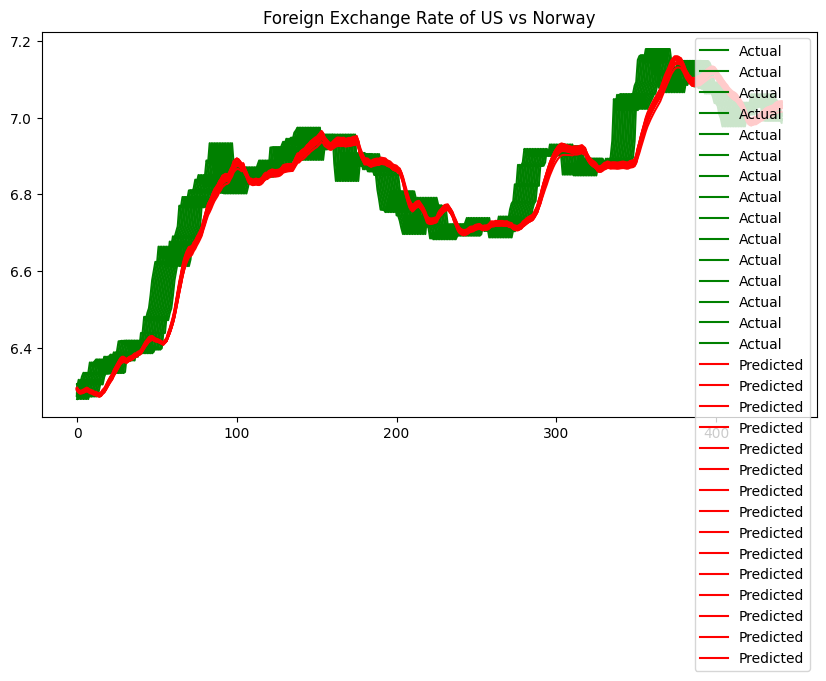

In [68]:
#Visualizing the results
plt.figure(figsize=(10,5))
plt.title('Foreign Exchange Rate of US vs Renminbi')
plt.plot(test_Y , label = 'Actual', color = 'g')
plt.plot(pred_Y , label = 'Predicted', color = 'r')
plt.legend()

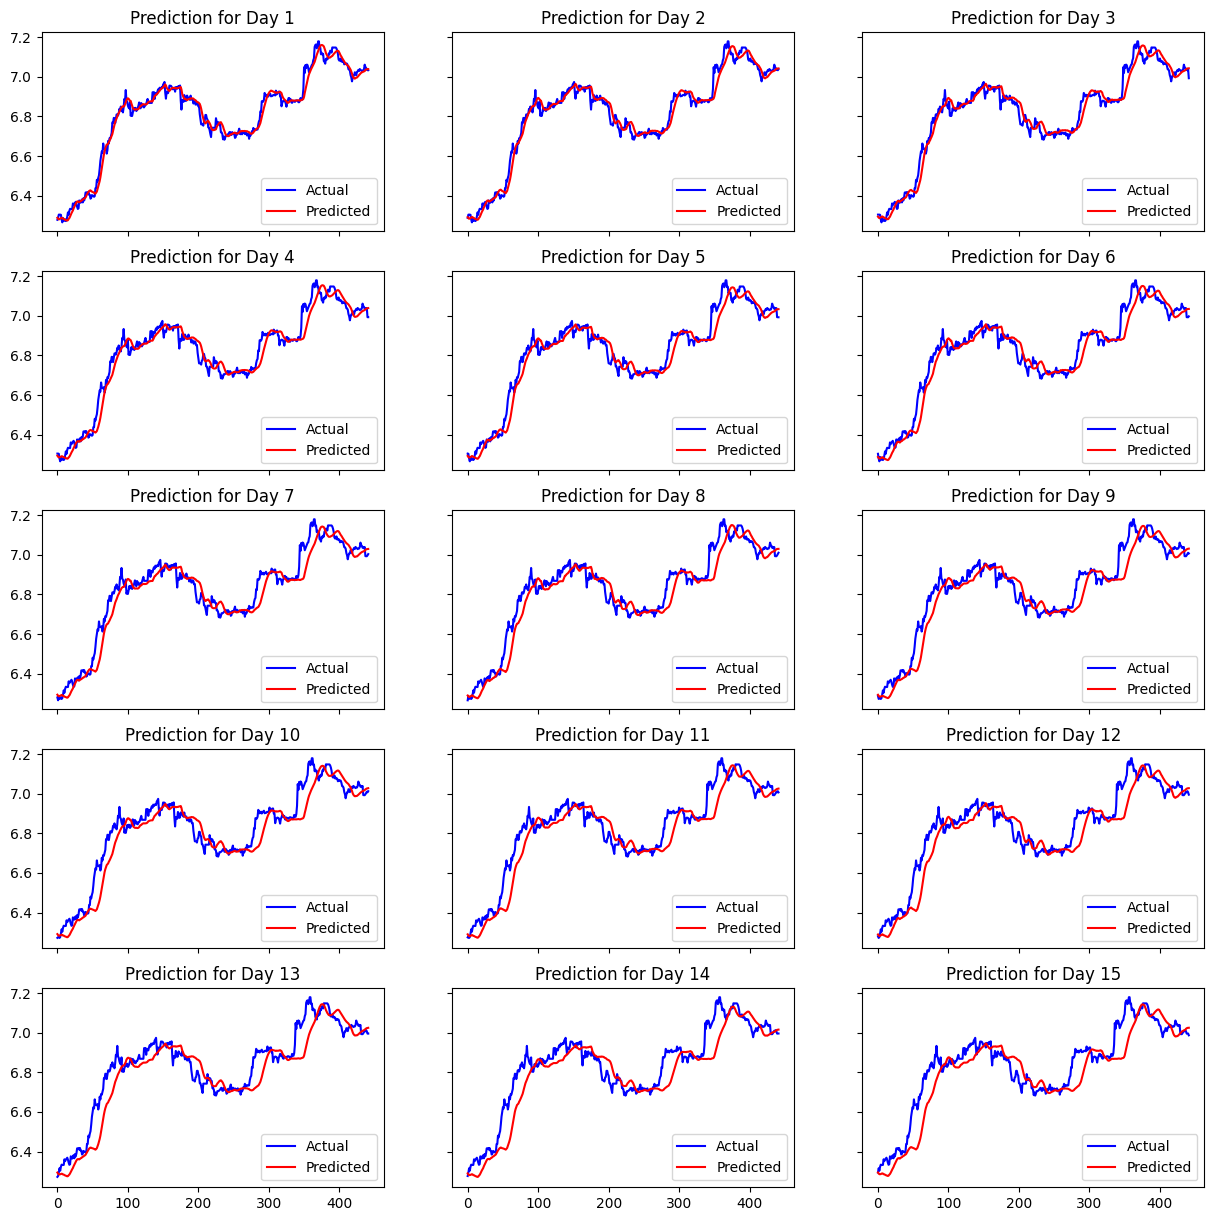

In [69]:
#Visualizing each day prediction results
# plt.figure(figsize=(30,25))
# plt.title('Foreign Exchange Rate of US vs Norway')

fig, axs = plt.subplots(5, 3, sharex='all', sharey='all', figsize=(15,15))

for i in range(predict_window):
  axs[i//3, i%3].plot(test_Y[:, i] , label = 'Actual', color = 'b')
  axs[i//3, i%3].plot(pred_Y[:, i] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Prediction for Day {i+1}")
  axs[i//3, i%3].legend()

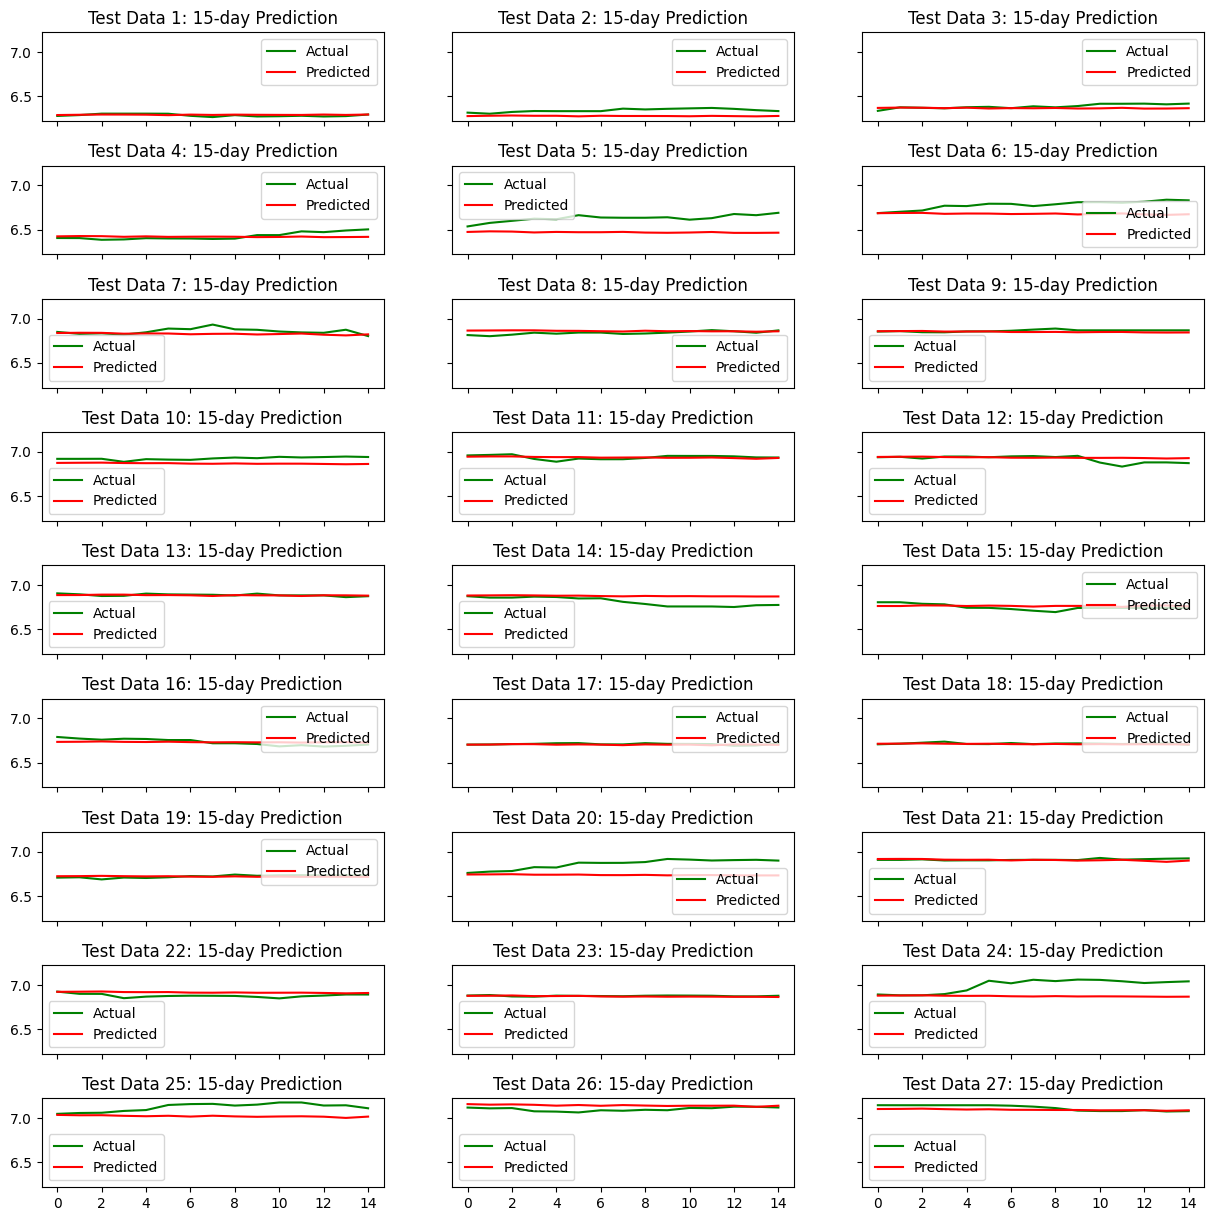

In [70]:
#Visualizing 15 test data for next 15 days prediction results

num_testdata = test_Y.shape[0] // predict_window
num_row = num_testdata // 3
fig, axs = plt.subplots(num_row, 3, sharex='all', sharey='all', figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(num_row * 3):
  axs[i//3, i%3].plot(test_Y[predict_window * i, :] , label = 'Actual', color = 'g')
  axs[i//3, i%3].plot(pred_Y[predict_window * i, :] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Test Data {i+1}: 15-day Prediction")
  axs[i//3, i%3].legend()

In [28]:
from sklearn.metrics import mean_squared_error
print((f"Prediction MSE for ALL"))
print(mean_squared_error(test_Y, pred_Y))
for i in range(predict_window):
  print((f"Prediction MSE for Day {i+1}"))
  print(mean_squared_error(test_Y[:, i], pred_Y[:, i]))

Prediction MSE for ALL
0.00517666017734515
Prediction MSE for Day 1
0.0017567256582760053
Prediction MSE for Day 2
0.0020073615534269345
Prediction MSE for Day 3
0.002368806725917955
Prediction MSE for Day 4
0.0028770847377276192
Prediction MSE for Day 5
0.002871476162925547
Prediction MSE for Day 6
0.004077340974042112
Prediction MSE for Day 7
0.004991853024727786
Prediction MSE for Day 8
0.005495158328607249
Prediction MSE for Day 9
0.005414480306862433
Prediction MSE for Day 10
0.005864963131114464
Prediction MSE for Day 11
0.006620744744171503
Prediction MSE for Day 12
0.0073605114939186665
Prediction MSE for Day 13
0.008424338423587061
Prediction MSE for Day 14
0.008767971973284713
Prediction MSE for Day 15
0.008751085421587215


# 利用DLinear预测US$/YUAN

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class PredictionModel(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(PredictionModel, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.device = configs.device

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


In [92]:
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
import random
import pandas as pd
import numpy as np
import os


class EXDataset(IterableDataset):
    def __init__(self, filepath, batch_size):
        self.filepath = filepath
        self.batch_size = batch_size

    def __iter__(self):
        return self

    def __next__(self):
        data = np.load(self.filepath)
        batches = np.array_split(data, len(data) // self.batch_size)
        for batch in batches:
            yield batch


In [93]:
class Config():

  def __init__(self, seq_len, pred_len, individual, enc_in, device, kernel_size=25):
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.individual = individual
    self.enc_in = enc_in
    self.kernel_size = kernel_size
    self.device = device

  def get_seq_len(self):
    return self.seq_len
  def set_seq_len(self, value):
    self.seq_len = value

  def get_pred_len(self):
      return self.pred_len
  def set_pred_len(self, value):
    self.pred_len = value

  def get_individual(self):
    return self.individual
  def set_individual(self, value):
    self.individual = value

  def get_enc_in(self):
    return self.enc_in
  def set_enc_in(self, value):
    self.enc_in = value

  def get_device(self):
    return self.device
  def set_device(self, value):
    self.device = value

  def get_kernel_size(self):
    return self.kernel_size
  def set_kernel_size(self, value):
    self.kernel_size = value

In [95]:
import time
import numpy as np
import tensorflow as tf


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
configs = Config(seq_len=60, pred_len=15, individual=False, enc_in=1, device=device, kernel_size = 7)
model = PredictionModel(configs).to(device)

epochs = 700
batch_size = 32
lr = 0.00005

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

filepath = '/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/'
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
start_time = time.time()
train_loss = []

for epoch in range(epochs):
  train_x = EXDataset(filepath + 'yuan-exr-train-x.npy', batch_size)
  train_y = EXDataset(filepath + 'yuan-exr-train-y.npy', batch_size)
  x_batches = next(iter(train_x))
  y_batches = next(iter(train_y))
  for x, y in zip(x_batches, y_batches):
    x = torch.from_numpy(x.astype(np.float32)).to(device)
    y = torch.from_numpy(y.astype(np.float32)).to(device)
    x = x.reshape(x.shape[0],x.shape[1], model.channels) #(batch, output_len, channel)
    y_pred = model(x)
    y_pred = y_pred.reshape(-1,y_pred.shape[1]) #(batch * channel, output_len)
    assert y_pred.shape == y.shape, f"y_pred shape is not equal to y shape"
    # print(y_pred[:5,:])
    # print(y[:5,:])
    loss = criterion(y_pred, y)
    train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"average train loss: {np.average(train_loss)}")
  train_loss = []

best_model_path = filepath + 'checkpoint.pth'
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, best_model_path)





average train loss: 0.40901169083857286
average train loss: 0.26644834825937225
average train loss: 0.1581156379381557
average train loss: 0.0901592356320988
average train loss: 0.050077242825257905
average train loss: 0.027402015758626577
average train loss: 0.014997204201386517
average train loss: 0.008428557785615945
average train loss: 0.005076079614809714
average train loss: 0.00343158931759212
average train loss: 0.0026484459037116417
average train loss: 0.002271538571120699
average train loss: 0.002071873300691449
average train loss: 0.0019435743482871556
average train loss: 0.001842233107784826
average train loss: 0.0017511540457791045
average train loss: 0.0016648067456799254
average train loss: 0.0015816607231929286
average train loss: 0.0015014571402313475
average train loss: 0.0014242898960345782
average train loss: 0.0013503365329496672
average train loss: 0.0012797752322436888
average train loss: 0.001212757625100696
average train loss: 0.0011494047914260995
average train

average train loss: 0.00021382099171773916
average train loss: 0.00021277720546524707
average train loss: 0.0002117424636733429
average train loss: 0.0002107163561472842
average train loss: 0.00020969921095254703
average train loss: 0.00020869073506762307
average train loss: 0.00020769111032513542
average train loss: 0.0002067004311767404
average train loss: 0.00020571870034460617
average train loss: 0.0002047457668999818
average train loss: 0.00020378184787419841
average train loss: 0.00020282671645096192
average train loss: 0.00020188051358142425
average train loss: 0.0002009432548912097
average train loss: 0.00020001494238720675
average train loss: 0.00019909535645802457
average train loss: 0.0001981843618763277
average train loss: 0.00019728199184498862
average train loss: 0.0001963880767242977
average train loss: 0.0001955026394063629
average train loss: 0.00019462535738846832
average train loss: 0.00019375617562092075
average train loss: 0.00019289528072066433
average train loss:

average train loss: 0.0001231833033175336
average train loss: 0.00012304499990594623
average train loss: 0.00012290823355382626
average train loss: 0.0001227729164049328
average train loss: 0.00012263903010357858
average train loss: 0.00012250661189957177
average train loss: 0.0001223754699424262
average train loss: 0.00012224575844754781
average train loss: 0.00012211735806823122
average train loss: 0.00012199023959722253
average train loss: 0.0001218643806674259
average train loss: 0.00012173988681733287
average train loss: 0.00012161662188248101
average train loss: 0.00012149450361991714
average train loss: 0.00012137364680045139
average train loss: 0.00012125402097653805
average train loss: 0.00012113560816828794
average train loss: 0.0001210183188220526
average train loss: 0.00012090223699503768
average train loss: 0.00012078735591182344
average train loss: 0.00012067349536771922
average train loss: 0.00012056083771483372
average train loss: 0.00012044920949784278
average train lo

average train loss: 0.00011105024353399686
average train loss: 0.00011102660181686967
average train loss: 0.00011100312631858363
average train loss: 0.00011097976154890905
average train loss: 0.00011095657203460026
average train loss: 0.00011093371893464464
average train loss: 0.00011091098318871673
average train loss: 0.00011088839505409472
average train loss: 0.00011086595196019289
average train loss: 0.00011084371344733452
average train loss: 0.0001108216513172364
average train loss: 0.00011079981214439588
average train loss: 0.00011077798734899286
average train loss: 0.00011075637814409826
average train loss: 0.00011073504560638664
average train loss: 0.00011071377018999506
average train loss: 0.00011069271700373899
average train loss: 0.0001106718712730665
average train loss: 0.00011065110204021443
average train loss: 0.00011063050190232262
average train loss: 0.0001106101059625707
average train loss: 0.00011058981741503733
average train loss: 0.00011056973265195009
average train 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/nor-exr-test-y.npy'

In [96]:
#Predict
# model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
test_x = EXDataset(filepath+'yuan-exr-test-x.npy', batch_size)
x_batches = next(iter(test_x))
y = np.load(filepath+'yuan-exr-test-y.npy')
y = torch.from_numpy(y.astype(np.float32))

outputs = []
with torch.no_grad():
  for x in x_batches:
    x = torch.from_numpy(x.astype(np.float32)).to(device)
    x = x.reshape(x.shape[0],x.shape[1], model.channels) #(batch, output_len, channel)
    output = model(x).detach().cpu().numpy()
    output = output.reshape(-1,output.shape[1]) #(batch * channel, output_len)
    print(f"output shape:{output.shape}")
    outputs.append(output)

y_pred = tf.concat(outputs, axis=0)
print(y.shape)


output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
output shape:(34, 15)
torch.Size([442, 15])


In [97]:
print(y_pred[:2,])

tf.Tensor(
[[0.1028073  0.10472889 0.10586941 0.10470305 0.10262035 0.10348475
  0.10377286 0.10401735 0.10657765 0.10472976 0.10455436 0.10471864
  0.10259083 0.1015972  0.10111732]
 [0.10827026 0.10896803 0.1088524  0.10705426 0.10670545 0.10749137
  0.10886641 0.10820473 0.10640475 0.10711856 0.10688439 0.10536852
  0.10689741 0.10472055 0.105372  ]], shape=(2, 15), dtype=float32)


In [99]:
print(y[:2,])

tensor([[0.1064, 0.1107, 0.1180, 0.1180, 0.1180, 0.1176, 0.1070, 0.1006, 0.1105,
         0.1037, 0.1049, 0.1072, 0.1036, 0.1055, 0.1135],
        [0.1107, 0.1180, 0.1180, 0.1180, 0.1176, 0.1070, 0.1006, 0.1105, 0.1037,
         0.1049, 0.1072, 0.1036, 0.1055, 0.1135, 0.1230]])


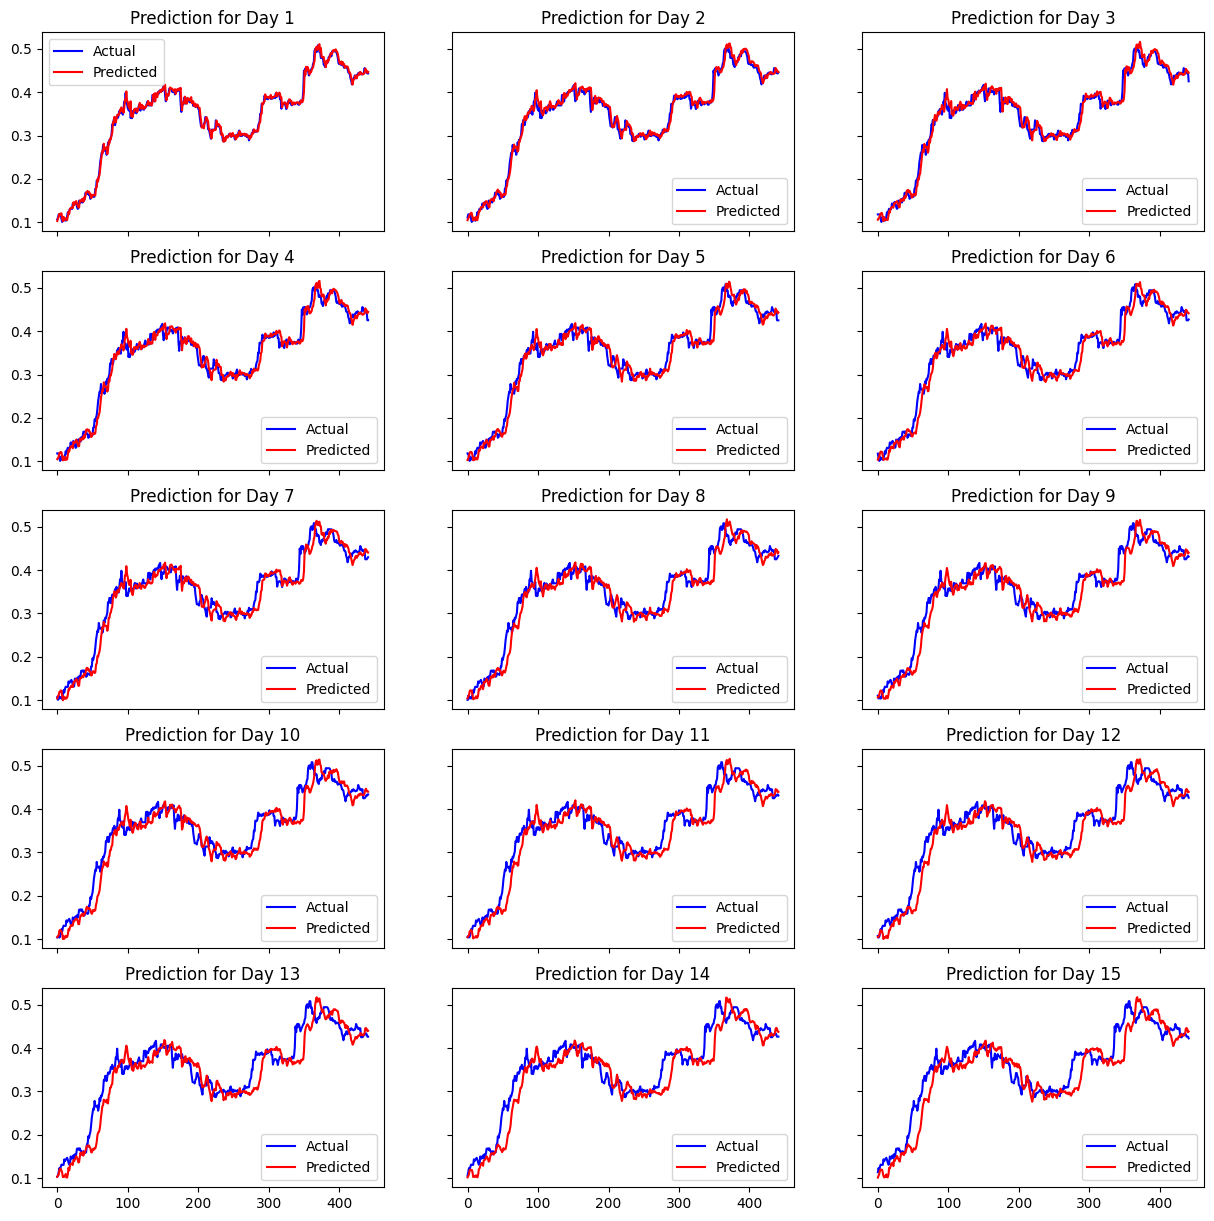

In [100]:
fig, axs = plt.subplots(5, 3, sharex='all', sharey='all', figsize=(15,15))

for i in range(configs.get_pred_len()):
  axs[i//3, i%3].plot(y[:, i] , label = 'Actual', color = 'b')
  axs[i//3, i%3].plot(y_pred[:, i] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Prediction for Day {i+1}")
  axs[i//3, i%3].legend()

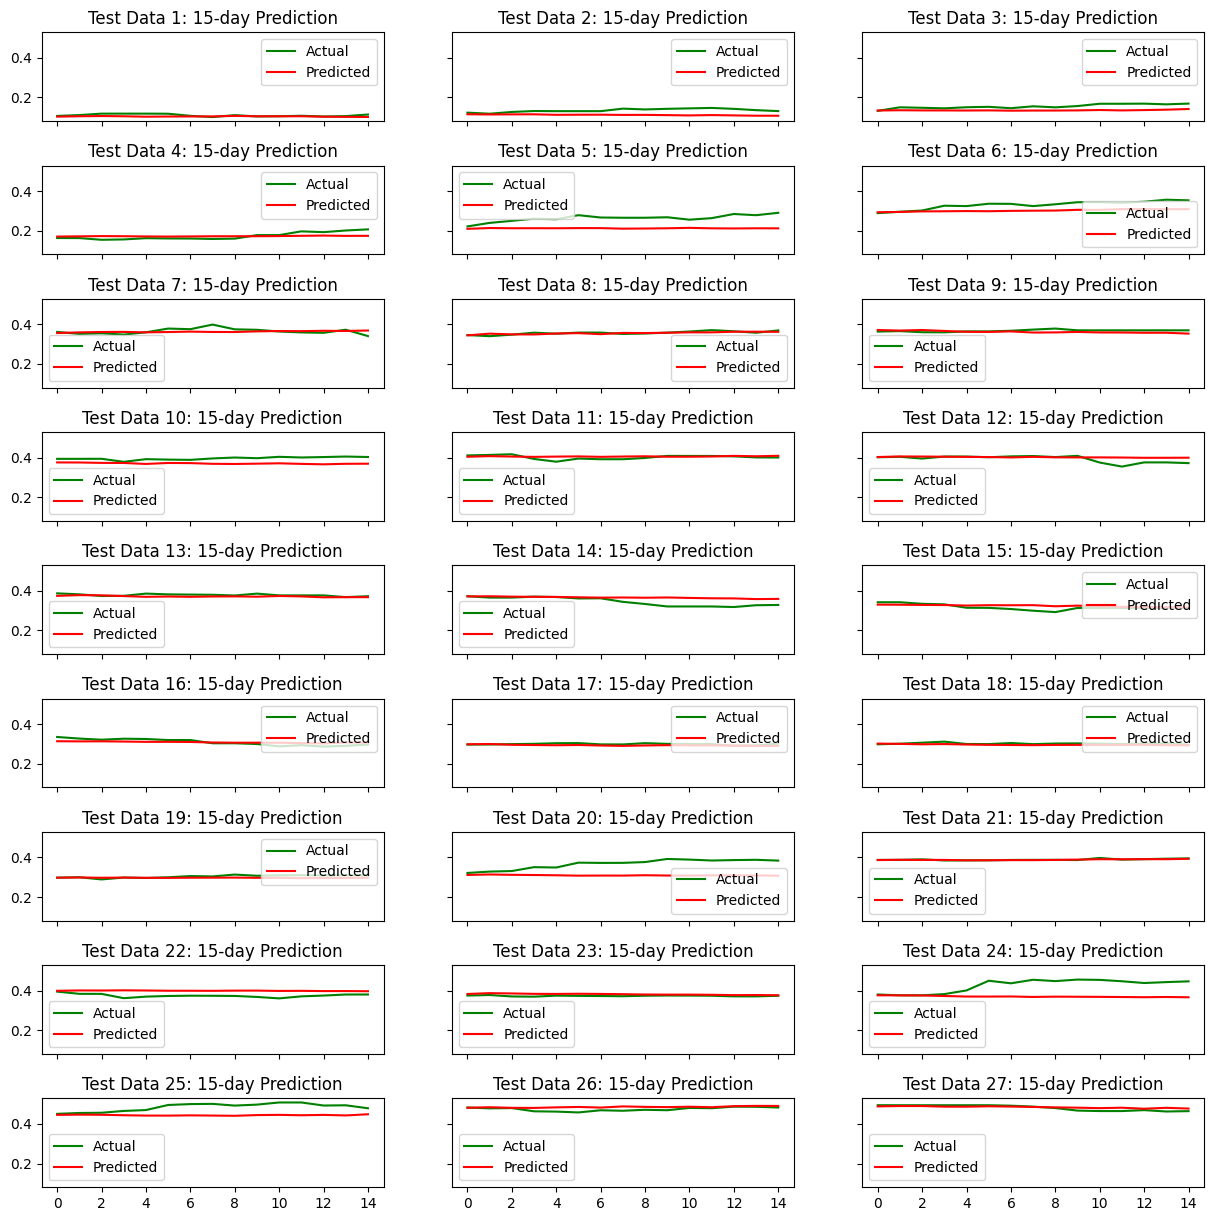

In [101]:
#Visualizing 15 test data for next 15 days prediction results

num_testdata = y.shape[0] // predict_window
num_row = num_testdata // 3
fig, axs = plt.subplots(num_row, 3, sharex='all', sharey='all', figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(num_row * 3):
  axs[i//3, i%3].plot(y[predict_window * i, :] , label = 'Actual', color = 'g')
  axs[i//3, i%3].plot(y_pred[predict_window * i, :] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Test Data {i+1}: 15-day Prediction")
  axs[i//3, i%3].legend()

In [102]:
from sklearn.metrics import mean_squared_error
print((f"Prediction MSE for ALL"))
print(mean_squared_error(y, y_pred))
for i in range(predict_window):
  print((f"Prediction MSE for Day {i+1}"))
  print(mean_squared_error(y[:, i], y_pred[:, i]))

Prediction MSE for ALL
0.0006096485
Prediction MSE for Day 1
6.866582e-05
Prediction MSE for Day 2
0.00012913377
Prediction MSE for Day 3
0.00019180219
Prediction MSE for Day 4
0.00026327462
Prediction MSE for Day 5
0.0003470809
Prediction MSE for Day 6
0.0004308496
Prediction MSE for Day 7
0.0005124946
Prediction MSE for Day 8
0.0006115695
Prediction MSE for Day 9
0.00068501744
Prediction MSE for Day 10
0.000763544
Prediction MSE for Day 11
0.00084136124
Prediction MSE for Day 12
0.0009266561
Prediction MSE for Day 13
0.001027522
Prediction MSE for Day 14
0.0011260534
Prediction MSE for Day 15
0.0012197009
